# [Assignment 4](https://ovgu-ailab.github.io/idl2023/assignment4.html)

collaborative work from Adrian Bremer & Philipp Reinig

## Setup



In [1]:
import tensorflow as tf
import keras
import numpy as np
from datetime import datetime

2023-11-06 10:09:07.709901: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 10:09:07.857119: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 10:09:07.857177: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 10:09:07.857682: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 10:09:07.922806: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 10:09:07.924185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Graph based execution

Trying out tf.function on MLP from assignment 2

In [8]:
class MLP:
    
    def __init__(self, layer_sizes, init_val):
        if len(layer_sizes) <= 1:
            raise AssertionError("There has to be at least 2 layers. 'layer_sizes' was {}".format(layer_sizes))
        
        self.weights = [tf.Variable(np.random.uniform(low=-init_val, high=init_val, size=(layer_sizes[i], layer_sizes[i+1])).astype(np.float32)) for i in range(len(layer_sizes)-1)]
        self.biases = [tf.Variable(np.zeros(layer_sizes[i]).astype(np.float32)) for i in range(1,len(layer_sizes))]
    
    def model(self, input_batch):
        """returns the logits for a given input batch"""
        
        n = len(self.biases)
        if n == 1:
            return tf.matmul(input_batch, self.weights[0]) + self.biases[0]
        
        next_input = input_batch
        for i in range(n-1):
            next_input = tf.nn.leaky_relu(tf.matmul(next_input, self.weights[i]) + self.biases[i])
        
        return tf.matmul(next_input, self.weights[n-1]) + self.biases[n-1]
    
    def train(self, imgs, lbls, learning_rate):
        """returns the cross entropy error"""
        n = len(self.biases)
      
        with tf.GradientTape() as tape:
            logits = self.model(imgs)
            xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits, labels=lbls))
        
        grads = tape.gradient(xent, self.weights + self.biases)
        for i in range(n):
            self.weights[i].assign_sub(learning_rate * grads[i])
            self.biases[i].assign_sub(learning_rate * grads[n+i])
        
        return xent

In [9]:
class graph_MLP:
    
    def __init__(self, layer_sizes, init_val):
        if len(layer_sizes) <= 1:
            raise AssertionError("There has to be at least 2 layers. 'layer_sizes' was {}".format(layer_sizes))
        
        self.weights = [tf.Variable(np.random.uniform(low=-init_val, high=init_val, size=(layer_sizes[i], layer_sizes[i+1])).astype(np.float32)) for i in range(len(layer_sizes)-1)]
        self.biases = [tf.Variable(np.zeros(layer_sizes[i]).astype(np.float32)) for i in range(1,len(layer_sizes))]
    
    def model(self, input_batch):
        """returns the logits for a given input batch"""
        
        n = len(self.biases)
        if n == 1:
            return tf.matmul(input_batch, self.weights[0]) + self.biases[0]
        
        next_input = input_batch
        for i in range(n-1):
            next_input = tf.nn.leaky_relu(tf.matmul(next_input, self.weights[i]) + self.biases[i])
        
        return tf.matmul(next_input, self.weights[n-1]) + self.biases[n-1]
    
    @tf.function
    def train(self, imgs, lbls, learning_rate):
        """returns the cross entropy error"""
        n = len(self.biases)
      
        with tf.GradientTape() as tape:
            logits = self.model(imgs)
            xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits, labels=lbls))
        
        grads = tape.gradient(xent, self.weights + self.biases)
        for i in range(n):
            self.weights[i].assign_sub(learning_rate * grads[i])
            self.biases[i].assign_sub(learning_rate * grads[n+i])
        
        return xent
            
            

In [12]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.mnist.load_data()

train_data = tf.data.Dataset.from_tensor_slices(
    (train_imgs.reshape((-1, 784)).astype(np.float32) / 255, train_lbls.astype(np.int32))).shuffle(buffer_size=60000).batch(128).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (test_imgs.reshape((-1, 784)).astype(np.float32) / 255, test_lbls.astype(np.int32))).batch(128)


In [14]:
mlp_times = []
for _ in range(10):
    start = datetime.now()
    mlp = MLP([784, 200, 10], 0.1)
    for i, (imgs, lbls) in enumerate(train_data):
        if i > 2000:
            break
        mlp.train(imgs, lbls, 0.1)
    mlp_times.append(datetime.now() - start)

g_mlp_times = []
for _ in range(10):
    start = datetime.now()
    g_mlp = graph_MLP([784, 200, 10], 0.1)
    for i, (imgs, lbls) in enumerate(train_data):
        if i > 2000:
            break
        g_mlp.train(imgs, lbls, 0.1)
    g_mlp_times.append(datetime.now() - start)
    
print("eager: mean = {}".format(np.mean(mlp_times)))
print("graph: mean = {}".format(np.mean(g_mlp_times)))

eager: mean = 0:00:08.766914
graph: mean = 0:00:04.668776


## ResNet
### Setup cifar-10

## Setup cifar-10

In [3]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.cifar10.load_data()

print(train_imgs.shape)

train_data = tf.data.Dataset.from_tensor_slices((train_imgs.astype(np.float32) / 255, train_lbls.astype(np.int32))).shuffle(buffer_size=60000).batch(128).repeat()
test_data = tf.data.Dataset.from_tensor_slices((test_imgs.astype(np.float32) / 255, test_lbls.astype(np.int32))).batch(128)

170498071/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3)


# Residual Blocks


In the paper one residual block has 2 convolutional layers with the same parameters, but when the number of channels increases use stride of 2 to reduce image size per channel.

In [69]:

def resblock(x, filters, kernel_size):
  in_channels = x.shape[3]
  stride = 1
  add_x = x
  if 2*in_channels == filters:
    # assume
    stride = 2
    add_x = keras.layers.Conv2D(filters, 1, stride, padding="same")(x)
  elif in_channels == filters:
    pass
  #else:
  #  raise AssertionError("When changing dimensions (filters) it has to be doubled.")

  out = keras.layers.Conv2D(filters, kernel_size, stride, activation="relu", padding="same")(x)
  out = keras.layers.BatchNormalization()(out)
  out = keras.layers.Conv2D(filters, kernel_size, activation="relu", padding="same")(out)
  out = keras.layers.Add()([add_x, out])
  out = keras.layers.ReLU()(out)
  out = keras.layers.BatchNormalization()(out)

  return out

def res_block(x, layers):
  out = x
  for i, layer in enumerate(layers):
    if i > 0:
      out = keras.layers.BatchNormalization()(out)
    out = layer(out)

  out = keras.layers.Add()([x, out])
  out = keras.layers.ReLU()(out)
  out = keras.layers.BatchNormalization()(out)

  return out

# Input: (x: Con, [Conv2D.Layer's])
# Output: last_layer

### Test model

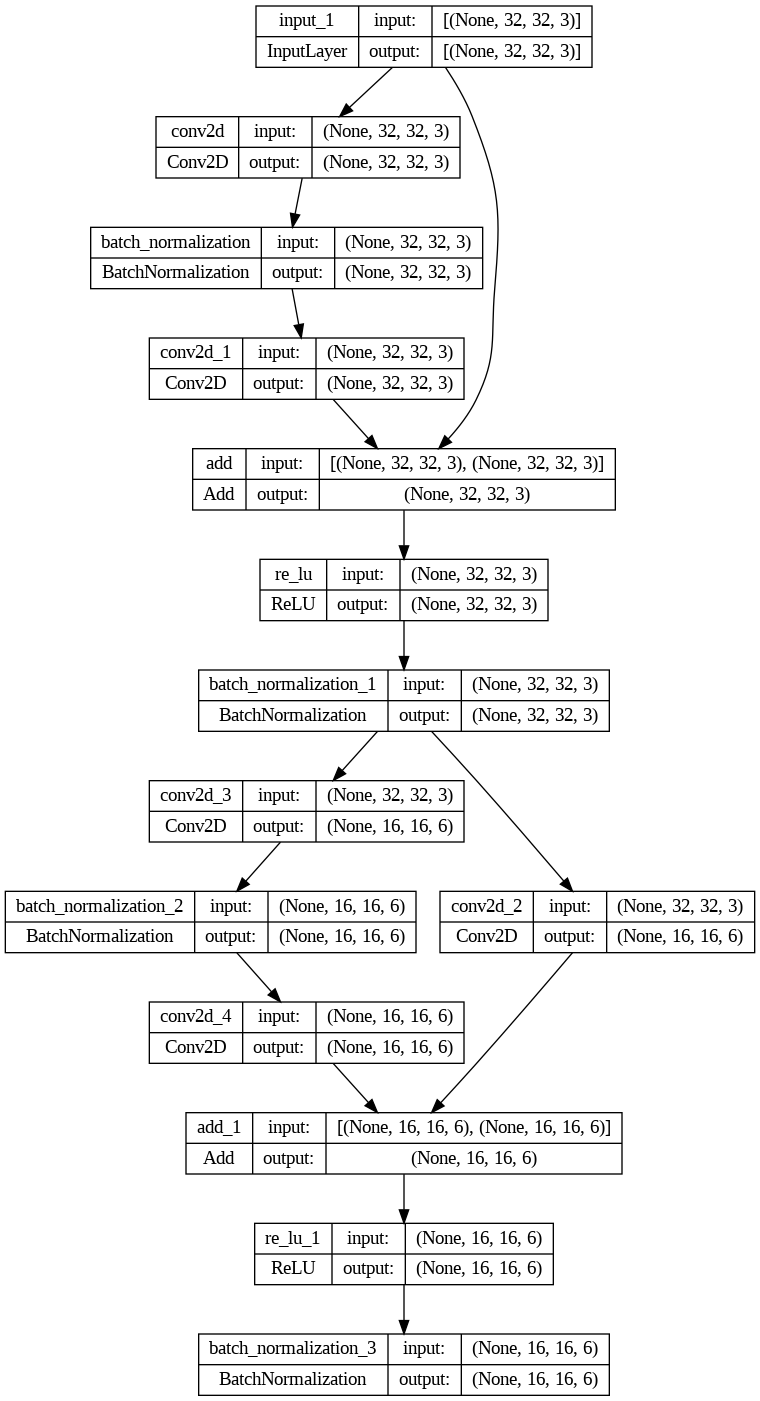

In [5]:
input = keras.Input(shape=(32,32,3))

out = resblock(input, 3, 3)
out = resblock(out, 6, 3)

model = keras.Model(inputs=input, outputs=out)
keras.utils.plot_model(model, show_shapes=True)

In [6]:
input = keras.Input(shape=(32,32,3))

print(input)

output = res_block(input, [keras.layers.Conv2D(3, 7, strides=(1,1), padding="same"),
                    keras.layers.Conv2D(3, 7, strides=(1,1), padding="same")])
print(output)

output_2 = res_block(output, [keras.layers.Conv2D(3, 3, strides=(2,2), padding="same"),
                    keras.layers.Conv2D(3, 3, strides=(2,2), padding="same")])


model = keras.Model(inputs=input, outputs=output_2)
model.summary()
keras.utils.plot_model(model, show_shapes=True)




KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), name='batch_normalization_5/FusedBatchNormV3:0', description="created by layer 'batch_normalization_5'")


ValueError: ignored

In [16]:

def group_of_resblocks(n, x, filters, kernel_size):
  out = x
  for _ in range(n):
    out = resblock(out, filters, kernel_size)
  return out

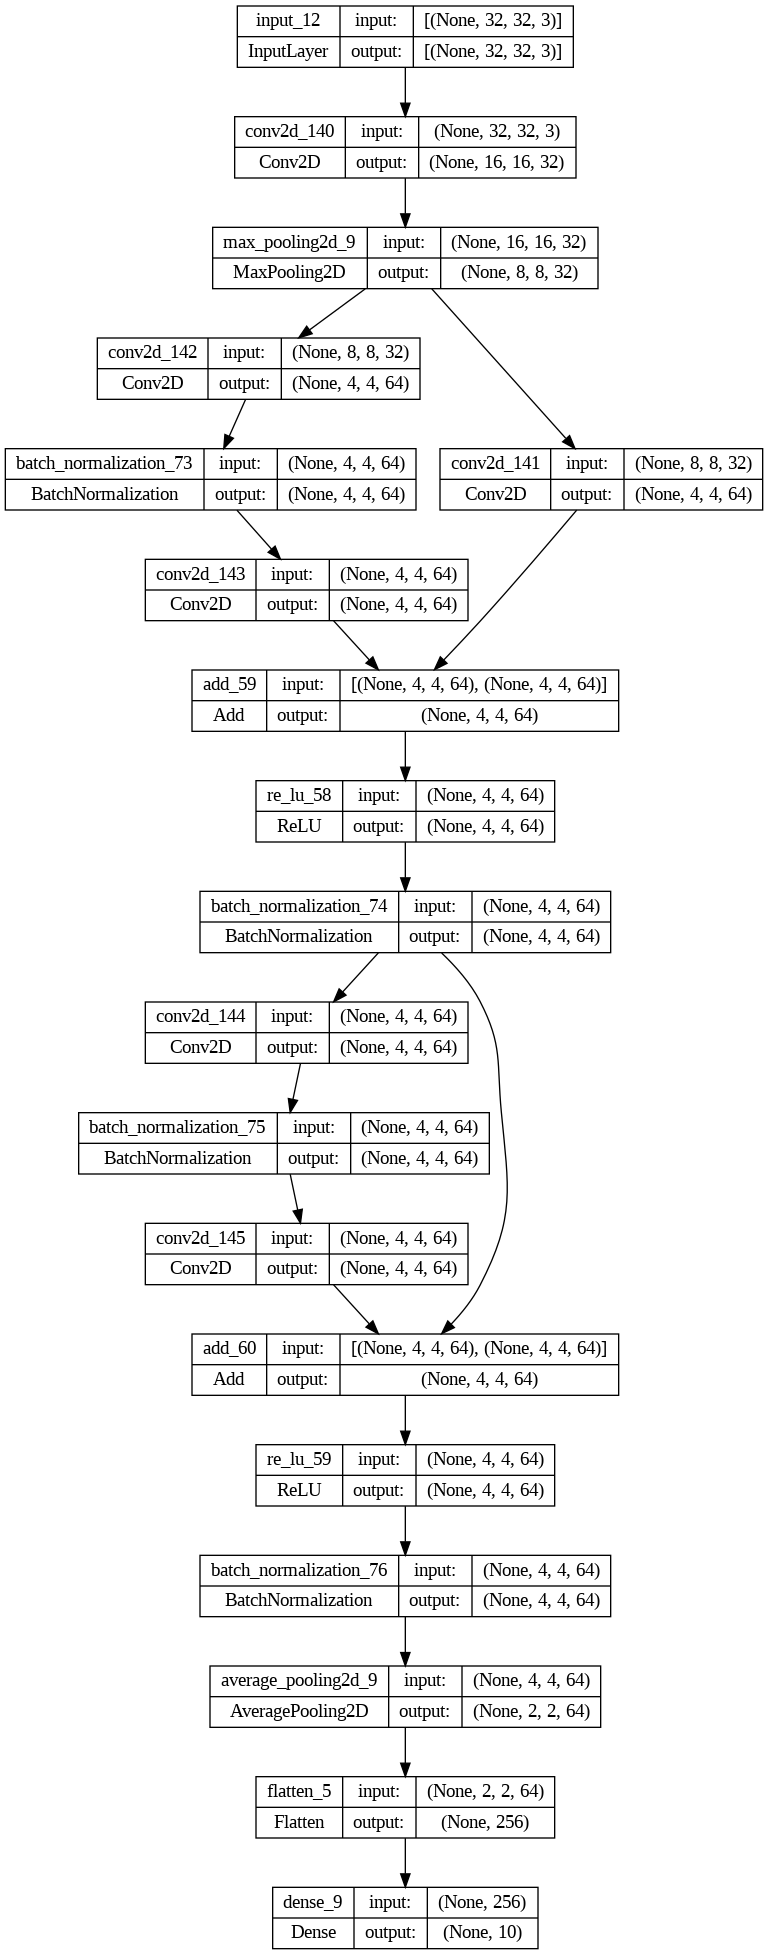

In [36]:
input = keras.Input(shape=(32,32,3))
out = keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding="same")(input)
out = keras.layers.MaxPooling2D()(out)
out = group_of_resblocks(2, out, 64, 3)
#out = group_of_resblocks(2, out, 128, 3)
#out = group_of_resblocks(6, out, 256, 3)
#out = group_of_resblocks(3, out, 512, 3)
out = keras.layers.AveragePooling2D()(out)
out = keras.layers.Flatten()(out)
out = keras.layers.Dense(10)(out)

model = keras.Model(inputs=input, outputs=out, name="copy_from_paper")

model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

keras.utils.plot_model(model, show_shapes=True)

In [37]:
model.fit(train_data, epochs=15, steps_per_epoch=500)

Epoch 1/15
500/500 [==============================] - 7s 8ms/step - loss: 1.3500 - accuracy: 0.5120
Epoch 2/15
500/500 [==============================] - 3s 7ms/step - loss: 0.9706 - accuracy: 0.6563
Epoch 3/15
500/500 [==============================] - 3s 7ms/step - loss: 0.8015 - accuracy: 0.7184
Epoch 4/15
500/500 [==============================] - 4s 8ms/step - loss: 0.6728 - accuracy: 0.7658
Epoch 5/15
500/500 [==============================] - 3s 7ms/step - loss: 0.5593 - accuracy: 0.8025
Epoch 6/15
500/500 [==============================] - 3s 7ms/step - loss: 0.4855 - accuracy: 0.8294
Epoch 7/15
500/500 [==============================] - 4s 7ms/step - loss: 0.4185 - accuracy: 0.8522
Epoch 8/15
500/500 [==============================] - 4s 8ms/step - loss: 0.3293 - accuracy: 0.8872
Epoch 9/15
500/500 [==============================] - 3s 7ms/step - loss: 0.2694 - accuracy: 0.9084
Epoch 10/15
500/500 [==============================] - 3s 7ms/step - loss: 0.2315 - accuracy: 0.9203

In [38]:
model.evaluate(test_data)

79/79 [==============================] - 0s 4ms/step - loss: 1.4695 - accuracy: 0.6983


[1.4694596529006958, 0.6983000040054321]

- keep it simple -> small networks perform better
- when training too long it seems that overfitting kicks in easily
- easy to reach 96% accuracy on training data, but hard to balance it to get high accuracy on test data

- batch normalization makes it faster in learning and it achieves better test data accuracy

# Trying out different architecture

In [39]:
# Trying out different architecture

input = keras.Input(shape=(32,32,3))
out = keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(input)
out = keras.layers.BatchNormalization()(out)
out = resblock(out, 16, 3)
out = resblock(out, 32, 3)
out = resblock(out, 64, 3)
out = keras.layers.AveragePooling2D(pool_size=8)(out)
out = keras.layers.Flatten()(out)
out = keras.layers.Dense(10)(out)

model = keras.Model(inputs=input, outputs=out, name="ResNet_towardsdatascience")

model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

#keras.utils.plot_model(model, show_shapes=True)

In [40]:
model.fit(train_data, epochs=10, steps_per_epoch=500)

Epoch 1/10
500/500 [==============================] - 12s 14ms/step - loss: 1.3435 - accuracy: 0.5176
Epoch 2/10
500/500 [==============================] - 7s 13ms/step - loss: 0.9817 - accuracy: 0.6529
Epoch 3/10
500/500 [==============================] - 7s 14ms/step - loss: 0.8346 - accuracy: 0.7066
Epoch 4/10
500/500 [==============================] - 8s 16ms/step - loss: 0.7392 - accuracy: 0.7403
Epoch 5/10
500/500 [==============================] - 7s 15ms/step - loss: 0.6585 - accuracy: 0.7714
Epoch 6/10
500/500 [==============================] - 7s 14ms/step - loss: 0.5951 - accuracy: 0.7929
Epoch 7/10
500/500 [==============================] - 7s 13ms/step - loss: 0.5458 - accuracy: 0.8101
Epoch 8/10
500/500 [==============================] - 7s 14ms/step - loss: 0.4851 - accuracy: 0.8316
Epoch 9/10
500/500 [==============================] - 7s 13ms/step - loss: 0.4457 - accuracy: 0.8484
Epoch 10/10
500/500 [==============================] - 7s 14ms/step - loss: 0.4093 - accur

In [41]:
model.evaluate(test_data)

79/79 [==============================] - 1s 9ms/step - loss: 0.8689 - accuracy: 0.7107


[0.8689093589782715, 0.7106999754905701]

In [45]:
# Trying to improve
input = keras.Input(shape=(32,32,3))
out = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(input)
out = keras.layers.BatchNormalization()(out)
out = resblock(out, 32, 3)
out = resblock(out, 64, 3)
out = resblock(out, 128, 3)
out = resblock(out, 256, 3)
out = keras.layers.AveragePooling2D(pool_size=2)(out)
out = keras.layers.Flatten()(out)
out = keras.layers.Dense(10)(out)

model = keras.Model(inputs=input, outputs=out, name="ResNet_towardsdatascience")

model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

for _ in range(20):
  model.fit(train_data, epochs=1, steps_per_epoch=500)
  model.evaluate(test_data)

79/79 [==============================] - 1s 9ms/step - loss: 1.0341 - accuracy: 0.8061


- more channels = better


# Putting resblock in a layer

In [85]:
class ResBlock(keras.layers.Layer):
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.filters=filters
    self.kernel_size=kernel_size

  def __call__(self, inputs):
    in_channels = inputs.shape[3]
    stride = 1
    add_inputs = inputs
    if 2*in_channels == self.filters:
      # assume
      stride = 2
      add_inputs = keras.layers.Conv2D(self.filters, 1, stride, padding="same")(inputs)
    elif in_channels == self.filters:
      pass
    else:
      raise AssertionError("When changing dimensions (self.filters) it has to be doubled.")

    out = keras.layers.Conv2D(self.filters, self.kernel_size, stride, activation="relu", padding="same")(inputs)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Conv2D(self.filters, self.kernel_size, activation="relu", padding="same")(out)
    out = keras.layers.Add()([add_inputs, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.BatchNormalization()(out)

    return out

#@tf.function
#def graph_resblock(x, filters, kernel_size):
#  return resblock(x, filters, kernel_size)

class ResBlockGraph(keras.layers.Layer):
  def __init__(self, filters, kernel_size, stride_in_first_conv_layer=(1,1)):
    super().__init__()
    self.filters=filters
    self.kernel_size=kernel_size
    #self.stride=stride_in_first_conv_layer

  def __call__(self, inputs):
    #return graph_resblock(inputs, self.filters, self.kernel_size)

    in_channels = inputs.shape[3]
    add_inputs = inputs
    out = inputs
    if 2*inputs.shape[3] == self.filters:
      out = keras.layers.Conv2D(self.filters, self.kernel_size, 2, activation="relu", padding="same")(out)
      add_inputs = keras.layers.Conv2D(self.filters, 1, 2, padding="same")(inputs)
    elif inputs.shape[3] == self.filters:
      out = keras.layers.Conv2D(self.filters, self.kernel_size, 1, activation="relu", padding="same")(out)
    else:
      raise AssertionError("When changing dimensions (self.filters) it has to be doubled.")

    #out = keras.layers.Conv2D(self.filters, self.kernel_size, self.stride, activation="relu", padding="same")(out)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Conv2D(self.filters, self.kernel_size, activation="relu", padding="same")(out)
    out = keras.layers.Add()([add_inputs, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.BatchNormalization()(out)

    return out


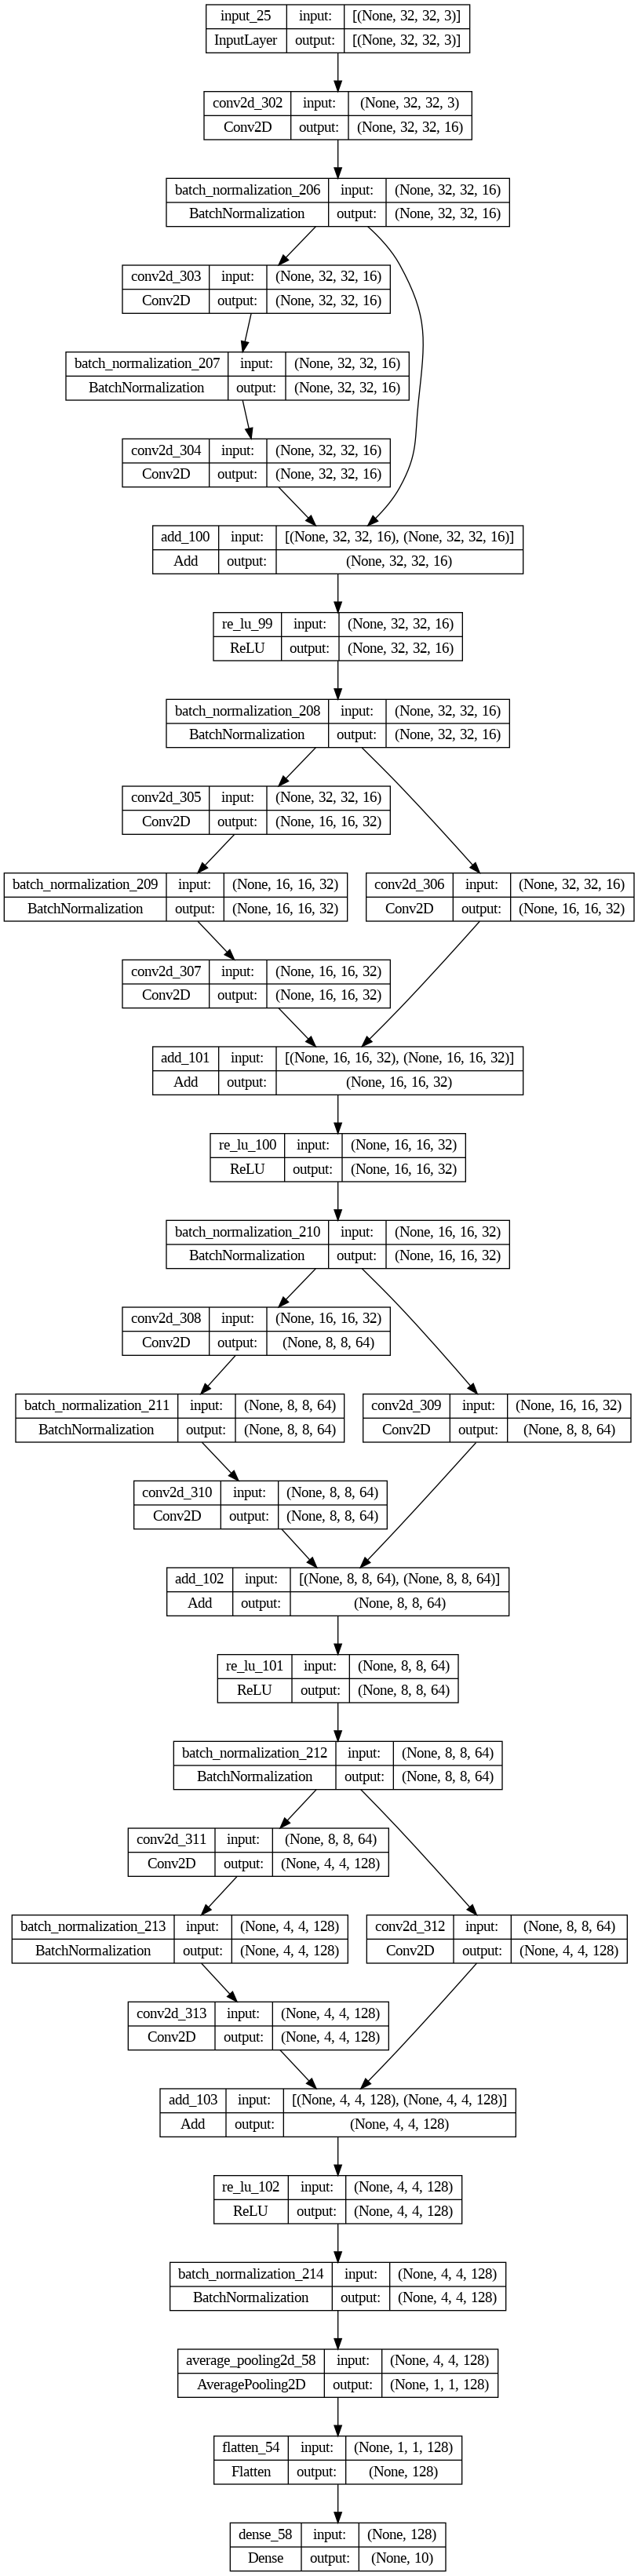

In [89]:
def init_normal():
  return keras.Sequential([
      keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same"),
      keras.layers.BatchNormalization(),
      ResBlock(16, 3),
      ResBlock(32, 3),
      ResBlock(64, 3),
      ResBlock(128, 3),
      keras.layers.AveragePooling2D(pool_size=2),
      keras.layers.Flatten(),
      keras.layers.Dense(10)
  ])

def init_graphbased():
  input = keras.Input(shape=(32,32,3))
  out = keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(input)
  out = keras.layers.BatchNormalization()(out)
  out = ResBlockGraph(16, 3)(out)
  out = ResBlockGraph(32, 3)(out)
  out = ResBlockGraph(64, 3)(out)
  out = ResBlockGraph(128, 3)(out)
  out = keras.layers.AveragePooling2D(pool_size=4)(out)
  out = keras.layers.Flatten()(out)
  out = keras.layers.Dense(10)(out)
  return keras.Model(inputs=input, outputs=out)

m_normal = init_normal()
m_graph = init_graphbased()

m_normal.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
m_graph.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

keras.utils.plot_model(m_graph, show_shapes=True)


In [93]:
@tf.function
def graph_train(model, train_data, epochs=10, steps_per_epoch=500):
  for _ in range(epochs):
    for _ in range(steps_per_epoch):
      logits = model(train_data)
      model.
  model(train_data, epochs=epochs, steps_per_epoch=steps_per_epoch)

graph_train(m_graph, train_data, epochs=10, steps_per_epoch=500)
print("======================")
m_normal.fit(train_data, epochs=10, steps_per_epoch=500)


SyntaxError: ignored